In [10]:
import pandas as pd

# TODO: update for state
STATE = 'philly' # 'ma' # 'ny'
# YEARS = [str(yr) for yr in range(2011, 2018)]
YEARS = [str(yr) for yr in range(2011, 2017)]

In [11]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}


def race_combine_other(row):
    """Combines the values for the other races with american indian, hawaiian, etc"""
    return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])


def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]
    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    df['HD01_VD07'] = df.apply(race_combine_other, axis=1)
    return preprocess_df(df, year, race_column_map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    column_map = income_column_map
    fname = get_fname(state, year, 'income')
    if fname in filename_income_column_map:
        column_map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    remove_labels(df)
    return preprocess_df(df, year, column_map)


In [12]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)

state_df.head()

handling files for year  2011
handling files for year  2012
handling files for year  2013
handling files for year  2014
handling files for year  2015
handling files for year  2016


,2011 median income,2011 median income margin of error,2011 race: total households,2011 race: total households margin of error,2011 race: White,2011 race: Black,2011 race: Asian,2011 race: Other,2011 race: 2 or more races,2012 median income,...,2015 race: 2 or more races,2016 median income,2016 median income margin of error,2016 race: total households,2016 race: total households margin of error,2016 race: White,2016 race: Black,2016 race: Asian,2016 race: Other,2016 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
42101000100,80813,11379,3027,345,2610,175,160,37,45,75505,...,90,103772,11761,4012,476,3020,500,358,36,98
42101000200,37483,13839,1897,278,406,23,1443,16,9,49928,...,64,50455,22642,2563,457,825,156,1389,59,134
42101000300,73556,11449,3365,362,2367,268,578,13,139,71250,...,77,93036,15233,3530,300,2740,150,447,46,147
42101000401,26547,6585,2034,263,1172,180,544,12,126,30000,...,37,57604,10786,2666,245,1605,346,663,8,44
42101000402,43838,10204,3198,264,2882,114,126,0,76,44805,...,45,70038,14655,3202,367,2721,178,249,0,54


In [13]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/philly/race_and_income_data.csv


In [17]:
import geopandas as gpd

In [18]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes
elif STATE == 'philly':
    shapefile_filename = get_filepath(STATE) + 'philly_census_tracts_shapefile_2010/Census_Tracts_2010.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes

shapefile_df.head()

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,geometry
0,1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429,"POLYGON ((-75.22926522780659 39.9605446656843,..."
1,2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430,"POLYGON ((-75.2353591940378 39.9685190282368, ..."
2,3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431,"POLYGON ((-75.2434277968255 39.9622970641896, ..."
3,4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468,"POLYGON ((-75.17340780671741 39.977792764172, ..."
4,5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469,"POLYGON ((-75.1731295290552 39.9777597701621, ..."


In [19]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head()

,Name,geometry
geoid,,
42101009400,Census Tract 94,"POLYGON ((-75.22926522780659 39.9605446656843,..."
42101009500,Census Tract 95,"POLYGON ((-75.2353591940378 39.9685190282368, ..."
42101009600,Census Tract 96,"POLYGON ((-75.2434277968255 39.9622970641896, ..."
42101013800,Census Tract 138,"POLYGON ((-75.17340780671741 39.977792764172, ..."
42101013900,Census Tract 139,"POLYGON ((-75.1731295290552 39.9777597701621, ..."


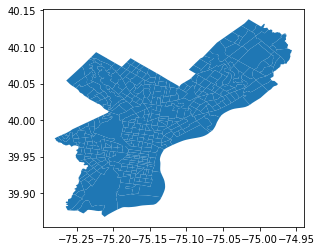

In [21]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [22]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (384, 56)


,Name,geometry,2011 median income,2011 median income margin of error,2011 race: total households,2011 race: total households margin of error,2011 race: White,2011 race: Black,2011 race: Asian,2011 race: Other,...,2015 race: 2 or more races,2016 median income,2016 median income margin of error,2016 race: total households,2016 race: total households margin of error,2016 race: White,2016 race: Black,2016 race: Asian,2016 race: Other,2016 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
42101009400,Census Tract 94,"POLYGON ((-75.22926522780659 39.9605446656843,...",19801,2734,3850,443,50,3696,21,0,...,101,18408,2838,4123,462,29,3912,0,57,125
42101009500,Census Tract 95,"POLYGON ((-75.2353591940378 39.9685190282368, ...",16786,2710,3339,471,15,3261,0,63,...,31,27708,12239,3065,458,164,2819,0,59,23
42101009600,Census Tract 96,"POLYGON ((-75.2434277968255 39.9622970641896, ...",26940,5434,4813,1013,52,4491,41,207,...,32,24402,2987,4311,591,83,4078,31,85,34
42101013800,Census Tract 138,"POLYGON ((-75.17340780671741 39.977792764172, ...",23177,5251,1840,217,74,1662,0,9,...,87,28534,7424,2118,254,315,1671,0,72,60
42101013900,Census Tract 139,"POLYGON ((-75.1731295290552 39.9777597701621, ...",14985,6491,3333,676,285,2895,7,83,...,12,14314,2676,2960,424,466,2421,10,53,10


In [23]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')

saving to  ../data/philly/philly_census_tracts.geojson
saved
